# Zonal statistics on a dataset

This notebook shows how to perform zonal statistics on a dataset of *Aedes aegypti* mosquitoes that cause malaria. We will load and plot the dataset, showcasing the use of the MemoryRaster class. Then we load GADM shapefiles for Vietnam and perform zonal statistics at admin level 2, obtaining a dataframe with a list of Vietnam admin2 regions with the zonal aggregated value. The dataset is taken from the following study:

> Moritz UG Kraemer, Marianne E Sinka, Kirsten A Duda, Adrian QN Mylne, Freya M Shearer, Christopher M Barker,
> Chester G Moore, Roberta G Carvalho, Giovanini E Coelho, Wim Van Bortel Guy Hendrickx, Francis Schaffner,
> Iqbal RF Elyazar, Hwa-Jen Teng, Oliver J Brady, Jane P Messina, David M Pigott, Thomas W Scott, David L Smith,
> GR William Wint, Nick Golding, Simon I Hay (2015)
> **The global distribution of the arbovirus vectors *Aedes aegypti* and *Ae. albopictus*** *eLife* **4**:e08347.
> https://doi.org/10.7554/eLife.08347

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import numpy as np
import geopandas as gpd
from rasterio.enums import Resampling

here = Path.cwd().parent / "data"

from geoglue.memoryraster import MemoryRaster

# Here we load data from a shapefile, but we can also use the
# geoglue.country module to fetch data directly from GADM or geoBoundaries
city_polygons = gpd.read_file(
    here / "vnm_adm_gov_20201027" / "vnm_admbnda_adm2_gov_20201027.shp"
)
print("  Number of city polygons =", len(city_polygons))
print("Vector co-ordinate system =", city_polygons.crs.srs)

  Number of city polygons = 708
Vector co-ordinate system = EPSG:4326


The above shapefile has 708 regions at the administrative area level 2 in Vietnam.
We want to calculate *Aedes aegypti* incidence given a global raster file of Aedes aegypti incidence, which we load below.
The `MemoryRaster.mask` function crops the raster to the overall geographical boundary of Vietnam.

/home/abhidg/ghq/github.com/kraemer-lab/geoglue/.venv/lib/python3.13/site-packages/matplotlib/colors.py:777: RuntimeWarning: overflow encountered in multiply
  xa *= self.N


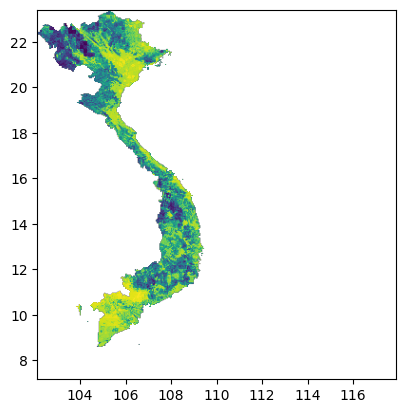

<Axes: >

In [3]:
aedes = MemoryRaster.read(here / "aegypti.tif", crs=city_polygons.crs.srs).mask(city_polygons)
aedes.plot()

In [4]:
aedes

<MemoryRaster (390, 378) CRS=EPSG:4326 min=0.006793989101065394 max=0.9826877668036827 NODATA=-1.7e+308 file=None
  transform=| 0.04, 0.00, 102.12|
| 0.00,-0.04, 23.42|
| 0.00, 0.00, 1.00|>

We also read in population data to peform weighted zonal statistics. Weighting by
population is often performed in epidemiological applications, as we want (possible)
predictive models to only take into account populated areas. Displaying the
`MemoryRaster` object shows metadata about the raster file, such as the shape,
Coordinate Reference Systems (CRS), minimum and maximum values, and nodata value
(values in the data representing NaN), and the affine transform that maps pixel
*(x, y)* coordinates to the CRS, such as *(longitude, latitude)*.

In [5]:
population_highres = (
    MemoryRaster.read(here / "VNM" / "worldpop" / "vnm_ppp_2020_UNadj_constrained.tif", crs=city_polygons.crs.srs)
    .mask(city_polygons).astype(np.float32)
)
population_highres

<MemoryRaster (17796, 8789) CRS=EPSG:4326 min=1.0159043073654175 max=28730.828125 NODATA=-99999.0 file=None
  transform=| 0.00, 0.00, 102.15|
| 0.00,-0.00, 23.39|
| 0.00, 0.00, 1.00|>

We can find the total population which should be about 100 million for Vietnam.
Doing sanity checks like these is important to ensure that the data is read in
properly and the code is working as intended.

In [6]:
population_highres.sum()

np.float32(97411280.0)

Before performing zonal statistics, we have to resample the population to match the *Aedes* raster so that the grids are aligned (this is required as the weight pixel is multiplied with the raster pixel). Alternatively, the *Aedes* raster could also be downsampled to match the population raster. We also have to choose a resampling strategy; in this case we sum over values while upsampling as this is a population count, for variables such as temperature, we would use aggregations like mean.

In [7]:
population_lowres = population_highres.resample(aedes, Resampling.sum)

We check the sum again after resampling -- this may not exactly be the same as the original and destination grid may not be integer multiples of each other, but should be close.

In [8]:
population_lowres.sum()

np.float32(97411256.0)

We can check that both the rasters are now the same shape:

In [9]:
print(aedes.shape, population_lowres.shape)

(390, 378) (390, 378)


To perform zonal statistics we only need a MemoryRaster and a geometry. In this case, we are performing weighted zonal statistics, so we need an additional weights raster. The `include_cols` specifies columns from the geometry dataframe to include in the returned output. The `include_geom` parameter is passed to exact_extract, which instructs it to return the geometry column, allowing the returned DataFrame to be plotted.

/home/abhidg/ghq/github.com/kraemer-lab/geoglue/.venv/lib/python3.13/site-packages/exactextract/exact_extract.py:330: RuntimeWarning: Spatial reference system of input features does not exactly match raster.
  warnings.warn(
/home/abhidg/ghq/github.com/kraemer-lab/geoglue/.venv/lib/python3.13/site-packages/exactextract/exact_extract.py:341: RuntimeWarning: Spatial reference system of input features does not exactly match weighting raster.
  warnings.warn(


<Axes: >

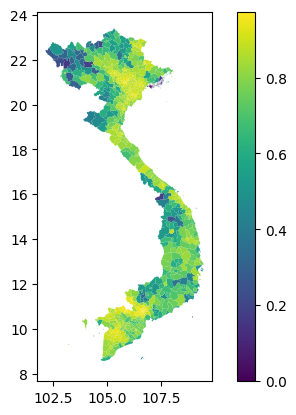

In [10]:
aedes_stats = aedes.zonal_stats(city_polygons, "weighted_mean", weights=population_lowres, include_geom=True)
aedes_stats.plot("weighted_mean", legend=True)

To get the population for each region, we can perform a (unweighted) zonal statistics on population with the same geometry:

In [11]:
pop = population_lowres.zonal_stats(city_polygons, 'sum', include_cols=['ADM2_EN', 'ADM1_EN'], include_geom=True)

/home/abhidg/ghq/github.com/kraemer-lab/geoglue/.venv/lib/python3.13/site-packages/exactextract/exact_extract.py:330: RuntimeWarning: Spatial reference system of input features does not exactly match raster.
  warnings.warn(


<Axes: >

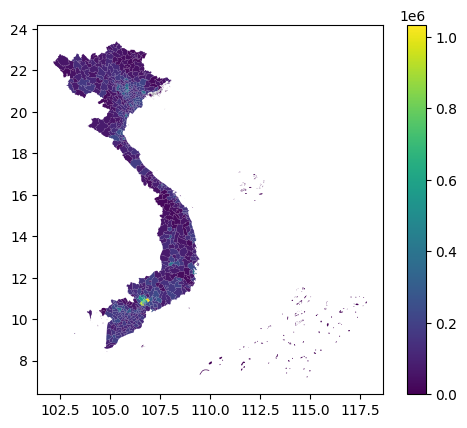

In [12]:
pop.plot("sum", legend=True)